<a href="https://colab.research.google.com/github/MohamedAbdelsalam9/IFT6135_Assignment1_Kaggle/blob/master/kaggle_run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import time
import numpy as np
import copy
import math
import os
import shutil
import datetime
import csv
from IPython.core.debugger import set_trace

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import transforms, datasets

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [0]:
#mount the google drive account to use the dataset
from google.colab import drive
drive.mount('/content/drive')

In [0]:
#Unzip the compressed files of the training set and test set
!unzip -q '/content/drive/My Drive/Data/CatsDogs/testset.zip'
!unzip -q '/content/drive/My Drive/Data/CatsDogs/trainset.zip'

In [44]:
##Create a validation set from the images whose id is a multiple of 5
data_dir = "/content"
train = "trainset"
validation = "validationset"
test = "testset"

train_dir = os.path.join(data_dir,train)
train_dogs_dir = f'{train_dir}/Dog'
train_cats_dir = f'{train_dir}/Cat'

val_dir = os.path.join(data_dir,validation)
val_dogs_dir = f'{val_dir}/Dog'
val_cats_dir = f'{val_dir}/Cat'

test_dir = os.path.join(data_dir,test)
test_dir = os.path.join(test_dir,'test')

try:  
  os.mkdir(val_dir)
  os.mkdir(val_dogs_dir)
  os.mkdir(val_cats_dir)
except OSError:  
  print (f"Creation of the directory {val_dir} failed")
else:  
  print (f"Successfully created the directory {val_dir}")

files = os.listdir(train_dir)
# Move all train cat images to cats folder, dog images to dogs folder
for i in range(10, 10000, 10):
  dog_file = str(i) + ".Dog.jpg"
  cat_file = str(i) + ".Cat.jpg"
  shutil.move(f'{train_dogs_dir}/{dog_file}', val_dogs_dir)
  shutil.move(f'{train_cats_dir}/{cat_file}', val_cats_dir)

Successfully created the directory /content/validationset


In [45]:
SAVE_PATH = '/content/drive/My Drive/IFT6135/CatsDogs'
seed = 1000
np.random.seed(seed)
torch.manual_seed(seed)

In [46]:
print (f"Number of dogs in training set: {len(os.listdir(train_dogs_dir))}")
print (f"Number of cats in training set: {len(os.listdir(train_cats_dir))}")
print (f"Number of dogs in validation set: {len(os.listdir(val_dogs_dir))}")
print (f"Number of cats in training set: {len(os.listdir(val_cats_dir))}")
print (f"Size of the test set: {len(os.listdir(test_dir))}")

Number of dogs in training set: 9000
Number of cats in training set: 9000
Number of dogs in validation set: 999
Number of cats in training set: 999
Size of the test set: 4999


In [0]:
#Create a new ImageFolder class that returns the image path as well
class ImageFolderWithPath(datasets.ImageFolder):
  def __getitem__(self, index):
    path, target = self.samples[index]
    sample = self.loader(path)
    if self.transform is not None:
      sample = self.transform(sample)
    if self.target_transform is not None:
      target = self.target_transform(target)

    return sample, target, path

In [48]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
#data_transforms = {train: transforms.Compose([transforms.RandomAffine(degrees=30, shear=10), 
#                                                transforms.RandomHorizontalFlip(),
#                                                transforms.RandomResizedCrop(64, scale=(0.8, 1.0), ratio=(0.75, 1.25)),
#                                                transforms.ToTensor(),
#                                                transforms.Normalize(mean, std)]),
#                   validation: transforms.Compose([transforms.Resize([64,64]),
#                                              transforms.ToTensor(),
#                                              transforms.Normalize(mean, std)]),
#                   test: transforms.Compose([transforms.Resize([64,64]),
#                                              transforms.ToTensor(),
#                                              transforms.Normalize(mean, std)])}
data_transforms = {train: transforms.Compose([transforms.RandomRotation(5), 
                                                transforms.RandomHorizontalFlip(),
                                                transforms.RandomResizedCrop(64, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
                                                transforms.ToTensor(),
                                                transforms.Normalize(mean, std)]),
                   validation: transforms.Compose([transforms.Resize([64,64]),
                                              transforms.ToTensor(),
                                              transforms.Normalize(mean, std)]),
                   test: transforms.Compose([transforms.Resize([64,64]),
                                              transforms.ToTensor(),
                                              transforms.Normalize(mean, std)])}
datasets_ = {dataset_type: datasets.ImageFolder(os.path.join(data_dir, dataset_type),data_transforms[dataset_type]) 
             for dataset_type in [train, validation]}
datasets_[test] = ImageFolderWithPath(os.path.join(data_dir, test),data_transforms[test])
dataloaders = {dataset_type: torch.utils.data.DataLoader(datasets_[dataset_type], batch_size=32,shuffle=True, num_workers=1) 
               for dataset_type in [train, validation]}
dataloaders[test] = torch.utils.data.DataLoader(datasets_[test], batch_size=32,shuffle=False, num_workers=1)

if (torch.cuda.is_available()):
  device = torch.device("cuda:0")
  cuda_available = True
  print ("GPU is available")
else:
  device = torch.device("cpu")
  cuda_available = False
  print ("GPU isn't available")

GPU is available


In [49]:
classes = datasets_[train].classes
dataset_sizes = {dataset_type: len(datasets_[dataset_type]) for dataset_type in [train, validation, test]}
print(f"Classes: {classes}")
print(f"Training set size: {dataset_sizes[train]}")
print(f"Validation set size: {dataset_sizes[validation]}")
print(f"Test set size: {dataset_sizes[test]}")

Classes: ['Cat', 'Dog']
Training set size: 18000
Validation set size: 1998
Test set size: 4999


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


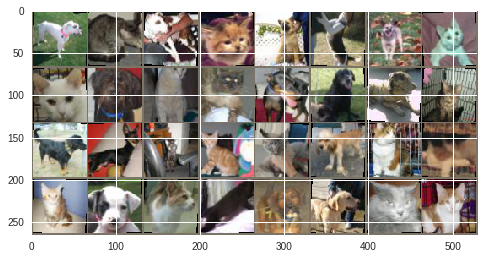

In [50]:
#get a sample of the training data
sample_images, _ = next(iter(dataloaders[train]))
sample_images = torchvision.utils.make_grid(sample_images)
sample_images = sample_images.numpy().transpose((1, 2, 0))
sample_images = std * sample_images + mean
plt.imshow(sample_images)
plt.pause(0.001)

In [0]:
class DropoutLayer(nn.Module):  
  def __init__(self,drop_prob):
    super(DropoutLayer, self).__init__()
    self.drop_prob = drop_prob
    
  def extra_repr(self):
    s = ('{drop_prob}')
    return s.format(**self.__dict__)

  def forward(self, x):
    # dropout is applied during training inly not inference
    if self.training:
      mask = (1-self.drop_prob) + torch.empty(x.shape).uniform_(0, 1)
      #used to create a binary mask for the input 
      mask = torch.floor(mask)
      mask = mask.to(device)
      return x * mask
    return x

In [0]:
#dropout specifically for conv2d layers
'''
`Efficient Object Localization Using Convolutional Networks`_ ,
    in this paper they describe the spatial dropout ,
    and to summarize it is used to reduce the number of feature maps that are strongly correlated
    which tends to happen in the early convolution layers.
'''
class SpatialDropoutLayer(nn.Module):
  def __init__(self,drop_prob):
    super(SpatialDropoutLayer, self).__init__()
    self.drop_prob = drop_prob
      
  def extra_repr(self):
    s = ('{drop_prob}')
    return s.format(**self.__dict__)
      
  def forward(self, x):
    # scaling to avoid changing of values of x when multiplying by the mask
    # dropout is applied during training only not inference
    if self.training:
      # batch size * number of channels
      mask_dim = [x.shape[0],x.shape[3]]
      mask = (1-self.drop_prob) + torch.empty(mask_dim).uniform_(0, 1)
      #used to create a binary mask for the input 
      mask = torch.floor(mask)
      mask = mask.view(-1,1,1,x.shape[3])
      mask = mask.to(device)
      return x * mask
    return x

In [0]:
class Classifier(nn.Module):
  def __init__(self):
    super(Classifier, self).__init__()
    self.conv00 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1)
    self.conv01 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1)
    self.conv02 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1)
    self.pool0 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
    self.conv10 = nn.Conv2d(in_channels=32, out_channels=48, kernel_size=(3, 3), padding=1)
    self.conv11 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=(3, 3), padding=1)
    self.conv12 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=(3, 3), padding=1)
    self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
    self.conv20 = nn.Conv2d(in_channels=48, out_channels=64, kernel_size=(3, 3), padding=1)
    self.conv21 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1)
    self.conv22 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1)
    self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
    self.FC0 = nn.Linear(4096, 100)
    self.FC1 = nn.Linear(100, 2)
    self.dropout = DropoutLayer(0.15)
    self.spatial_dropout =  SpatialDropoutLayer(0.2)
    self.relu = nn.LeakyReLU(0.2)

    self.level0_layers = (self.conv00, self.relu, self.pool0, 
                          self.conv10, self.relu, self.pool1, 
                          self.conv20, self.spatial_dropout, self.relu, self.pool2)
    self.level1_layers = (self.conv00, self.relu, self.conv01, self.relu, self.pool0,
                          self.conv10, self.relu, self.conv11, self.relu, self.pool1, 
                          self.conv20, self.spatial_dropout, self.relu, self.conv21, self.relu, self.pool2)
    self.level2_layers = (self.conv00, self.relu, self.conv01, self.relu, self.conv02, self.relu, self.pool0, 
                          self.conv10, self.relu, self.conv11, self.relu, self.conv12, self.relu, self.pool1, 
                          self.conv20, self.spatial_dropout, self.relu, self.conv21, self.relu, self.conv22, self.relu, self.pool2)
    self.FC_layers = (self.FC0, self.relu, self.dropout, self.FC1)

    self.levels = (self.level0_layers, self.level1_layers, self.level2_layers)
    self.levels_no = len(self.levels)
    self.level = 0

  def define_learning_level (self, level):
    self.level = level

  def forward(self, x):
    for layer in self.levels[self.level]:
      x = layer(x)
    x = x.view(x.size(0), -1)
    for FC_layer in self.FC_layers:
      x = FC_layer(x)
    return x

In [0]:
def print_network_info(model, optimizer, levels_interval, seed, checkpoint = None, LOG_PATH = None):
  print(f'''Training Data Transformations: {data_transforms[train].transforms}\n
  Optimizer Parameters: {optimizer.defaults}
  seed: {seed}
  Learning Levels: {model.levels_no}\nLearning Levels Interval: {levels_interval}
  Layers:\n''')
  parameters = 0
  for module in model.children():
    try:
      params = np.product(next(iter(module.parameters())).shape)
    except:
      params = 0

    print(f'{module}, parameters = {params}')
    parameters += params
  print (f'Total parameres = {parameters}\n')
  
  if LOG_PATH is not None:
    if checkpoint is None: 
      with open(LOG_PATH, "w") as file:
        file.write(f'Training Data Transformations: {data_transforms[train].transforms}\n\n')
        file.write(f'Optimizer Parameters: {optimizer.defaults}\n\n')
        file.write(f'seed: {seed}\n\n')
        file.write(f'Learning Levels: {model.levels_no}\nLearning Levels Interval: {levels_interval}\n\n')
        file.write("Layers:\n")
        parameters = 0
        for module in model.children():
          try:
            params = np.product(next(iter(module.parameters())).shape)
          except:
            params = 0

          file.write(f'{module}, parameters = {params}\n')
          parameters += params
        file.write (f'Total parameres = {parameters}\n\n')

In [0]:
def save_classified_samples(model, save_directory, date_, epoch):
  sample_images, targets = next(iter(dataloaders[validation]))
  sample_images, targets = sample_images.to(device), targets.to(device)
  outputs = model(sample_images)
  #set_trace()
  try:
    _, predicted = torch.max(outputs.data, 1)
    correct_images = sample_images[predicted == targets]
    wrong_images = sample_images[predicted != targets]
    correct_images = torchvision.utils.make_grid(correct_images)
    wrong_images = torchvision.utils.make_grid(wrong_images)
    correct_images = correct_images.cpu().numpy().transpose((1, 2, 0))
    correct_images = std * correct_images + mean
    wrong_images = wrong_images.cpu().numpy().transpose((1, 2, 0))
    wrong_images = std * wrong_images + mean
    mpimg.imsave(os.path.join(save_directory,'samples/'+str(epoch)+'_correct_'+date_+'.'+'png'), correct_images)
    mpimg.imsave(os.path.join(save_directory,'samples/'+str(epoch)+'_wrong_'+date_+'.'+'png'), wrong_images)
  except:
    print("Couldn't print image samples")

In [0]:
def init_stats(model, optimizer, levels_interval, seed, checkpoint = None):
  if checkpoint is not None:
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    model.define_learning_level(checkpoint['level'])
    stats = {'epoch_0': checkpoint['epoch']+1, 'seed': checkpoint['seed'], 'date_': checkpoint['date_'], 'total_time': checkpoint['total_time'], 
             'levels_interval': checkpoint['levels_interval'], 'loss_': checkpoint['loss_'], 'train_accuracy': checkpoint['train_accuracy'], 'val_accuracy': checkpoint['val_accuracy'], 
             'best_val_accuracy': checkpoint['best_val_accuracy']}
  else:
    date = datetime.datetime.now()
    stats = {'epoch_0': 1, 'seed': seed, 'date_': f'{date.year}_{date.month}_{date.day}_{date.hour}_{date.minute}', 'total_time': 0, 
            'levels_interval': levels_interval, 'loss_': 10, 'train_accuracy': 0, 'val_accuracy': 0, 'best_val_accuracy': 0}
  np.random.seed(stats['seed'])
  torch.manual_seed(stats['seed'])
  return stats

In [0]:
def Train(model, optimizer, criterion, epochs, seed = 1000, levels_interval = 10, save_interval = 5, checkpoint = None):
  
  stats = init_stats(model, optimizer, levels_interval, seed, checkpoint = checkpoint)

  if save_interval > 0:
    save_directory = os.path.join(SAVE_PATH,f"{int(stats['best_val_accuracy'])}_{stats['date_']}")
    LOG_PATH = os.path.join(save_directory, stats['date_'] + ".txt")
    if not os.path.exists(save_directory):
      os.makedirs(save_directory)
      os.makedirs(os.path.join(save_directory,'samples'))
      print_network_info(model, optimizer, stats['levels_interval'], stats['seed'], checkpoint, LOG_PATH)
  else:
    print_network_info(model, optimizer, stats['levels_interval'], stats['seed'])
  
  levels_no = model.levels_no
  lr_count = 0
  lr_interval = 5
  old_loss = 1
  loss_decrease = []
  for epoch in range(stats['epoch_0'], epochs+1):
      start = time.time()
      losses = []
      # Train
      model.train()
      level = model.level
      if (level < (levels_no-1)):
        new_level = math.ceil(epoch/stats['levels_interval']) - 1
        if level < new_level:
          model.define_learning_level(new_level)
           
      total = 0
      correct = 0
      for batch_idx, (inputs, targets) in enumerate(dataloaders[train]):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        losses.append(loss.data.item())  
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        if batch_idx%50==0:
          print('Epoch : %d Loss : %.3f ' % (epoch, np.mean(losses)))
      stats['train_accuracy'] = 100.*correct/total
      stats['loss_'] = np.mean(losses)
      
      if level == (levels_no - 1):
        loss_decrease.append(old_loss - stats['loss_'])
        if lr_count < lr_interval:
          lr_count += 1
        elif lr_count == lr_interval:
          loss_decrease.pop(0)
          
        if lr_count >= lr_interval:
          if sum(loss_decrease) < 0.01:
            optimizer.param_groups[0]['lr'] /= 5
            lr_count = 0
            loss_decrease[:] = []
            
        old_loss = stats['loss_']
      
      # Evaluate
      model.eval()
      total = 0
      correct = 0
      for batch_idx, (inputs, targets) in enumerate(dataloaders[validation]):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
      stats['val_accuracy'] = 100.*correct/total
      
      end = time.time()
      epoch_time = end-start
      e_hours = math.floor(epoch_time/60/60); e_mins = math.floor(epoch_time/60) - e_hours*60; e_secs = epoch_time % 60
      stats['total_time'] += epoch_time
      t_hours = math.floor(stats['total_time']/60/60); t_mins = math.floor(stats['total_time']/60) - t_hours*60; t_secs = stats['total_time'] % 60
      
      if (stats['val_accuracy'] > stats['best_val_accuracy']):
        stats['best_val_accuracy'] = stats['val_accuracy'] 
        if save_interval > 0:
          old_save_directory = save_directory
          save_directory = os.path.join(SAVE_PATH, f"{int(stats['best_val_accuracy'])}_{stats['date_']}")
          LOG_PATH = os.path.join(save_directory, stats['date_'] + ".txt")
          BEST_CHECK_POINT_PATH = os.path.join(save_directory,'Best_'+stats['date_']+'.'+'tar')
          os.rename(old_save_directory,save_directory)
          torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'levels_interval': stats['levels_interval'],
                      'level':model.level, 'loss_': stats['loss_'], 'train_accuracy': stats['train_accuracy'], 'val_accuracy': stats['val_accuracy'], 'date_': stats['date_'], 
                      'total_time': stats['total_time'], 'best_val_accuracy': stats['best_val_accuracy'], 'seed': stats['seed']}, BEST_CHECK_POINT_PATH)
          save_classified_samples(model, save_directory, stats['date_'], 'Best')
        
      print(f"Epoch : {epoch},  lr: {optimizer.param_groups[0]['lr']},  Loss: {stats['loss_']:.3f},  Train Acc: {stats['train_accuracy']:.1f}%,  Test Acc : {stats['val_accuracy']:.1f}%,  " \
      f"Best Test Acc : {stats['best_val_accuracy']:.1f}%,  Epoch Time : {e_hours}H {e_mins}M {e_secs:.0f}S,  Total Time : {t_hours}H {t_mins}M {t_secs:.0f}S")
      print('--------------------------------------------------------------')
      if save_interval > 0:
        with open(LOG_PATH, "a") as file: 
          file.write(f"Epoch : {epoch},  lr: {optimizer.param_groups[0]['lr']},  Loss: {stats['loss_']:.3f},  Train Acc: {stats['train_accuracy']:.1f}%,  "\
                     f"Test Acc : {stats['val_accuracy']:.1f}%, Best Test Acc : {stats['best_val_accuracy']:.1f}%,  Epoch Time : {e_hours}H {e_mins}M {e_secs:.0f}S,  "\
                     f"Total Time : {t_hours}H {t_mins}M {t_secs:.0f}S\n")
          file.write('--------------------------------------------------------------\n')
      
        if (epoch % save_interval == 0):
          CHECK_POINT_PATH = os.path.join(save_directory,str(epoch)+'_'+stats['date_']+'.'+'tar')
          torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'levels_interval': stats['levels_interval'],
                      'level':model.level, 'loss_': stats['loss_'], 'train_accuracy': stats['train_accuracy'], 'val_accuracy': stats['val_accuracy'], 'date_': stats['date_'], 
                      'total_time': stats['total_time'], 'best_val_accuracy': stats['best_val_accuracy'], 'seed': stats['seed']}, CHECK_POINT_PATH)
          save_classified_samples(model, save_directory, stats['date_'], epoch)

In [0]:
def Test(model, submission_path, checkpoint = None): 
  if checkpoint is not None:
    model.load_state_dict(checkpoint['model_state_dict'])
    model.define_learning_level(checkpoint['level'])
    
  model.eval()
  index = []
  output = []
  
  for batch_idx, (inputs, _, Paths) in enumerate(dataloaders[test]):
    inputs = inputs.to(device)
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    index += [path[:-4].replace(test_dir+'/','') for path in Paths]
    output += predicted.tolist()
  with open(os.path.join(submission_path,'submission_file.csv'), mode='w') as submission_file:
    submission_writer = csv.writer(submission_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    submission_writer.writerow(['id', 'label'])
    for i in range(len(index)):
      submission_writer.writerow([index[i], classes[output[i]]])
  print('Done')  

In [0]:
#checkpoint = torch.load(os.path.join(SAVE_PATH,'80_2019_2_11_5_42/10_2019_2_11_5_42.tar'))
checkpoint = None

#seeds = [1000, 800, 600, 400, 200, 1]
#for seed in seeds:
seed = 1000
np.random.seed(seed)
torch.manual_seed(seed)
model = Classifier()
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()
Train(model, optimizer, criterion, 80, seed = seed, save_interval = 5, checkpoint = checkpoint)

In [60]:
submission_path = os.path.join(SAVE_PATH,'93_2019_2_13_20_29')
checkpoint = torch.load(os.path.join(submission_path,'65_2019_2_13_20_29.tar'))
Test(model, submission_path = submission_path, checkpoint = checkpoint)

Done
